# EE267 Spring 2025 Term Project: Swimmer Segmentation and Pose Estimation

## Objective
Articial Intelligence (AI) has transformed computer vision, enabling machines to interpret visual data
much like humans. Two critical techniques in this field are image segmentation and human pose
estimation. Image segmentation isolates objects from their backgrounds, essential for tasks like sports
analysis and medical imaging. Human pose estimation, on the other hand, detects body joints and
movement, providing valuable insights for elds such as biomechanics and augmented reality.

In this assignment, we will do the following:
1. Segment the swimmer from the background using Meta's Segment Anything Model (SAM).
2. Detect and label the swimmer's joints using a human pose estimation model of your choice
(either YOLO or Meta Sapiens).

## Experiment

### Task 0: Data Pre-processing

Complete Guide to Image Preprocessing Techniques in Python: https://medium.com/@maahip1304/the-complete-guide-to-image-preprocessing-techniques-in-python-dca30804550c

Pre-Processing for Image Segmentation using Torchvision: https://pytorch.org/vision/master/auto_examples/transforms/plot_transforms_e2e.html (more up-to-date)

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision.transforms.v2 as transforms
from torchvision.transforms.functional import to_pil_image

# Data types
from typing import List
from numpy import ndarray
from torch import Tensor
from cv2 import VideoCapture
from torchvision.transforms.v2._container import Compose

In [3]:
# Image dataset folder paths
SWIM_VIDEO_FOLDER = 'data/Swim Videos/'
INPUT_IMAGES_FOLDER = 'data/input/'
SEGMENTED_IMAGES_FOLDER = 'data/segmented/'
KEYPOINTS_FOLDER = 'data/keypoints/'

# Image variables
IMAGE_SIZE = 256

#### Video Pre-processing

In [21]:
def get_frame(video_tensor: Tensor, idx: int = 0) -> Tensor:
    """
    Get a specific frame from a video tensor.
    
    Args:
        video_tensor (Tensor): The video tensor.
        idx (int): The index of the frame to extract.
        
    Returns:
        Tensor: The extracted frame.
    """
    return video_tensor[:, idx, :, :]

In [22]:
def preprocess_video(video_path: VideoCapture, frame_transforms: Compose, max_frames: int = None) -> Tensor:
    """Pre-process video frame by frame based on provided transforms

    Args:
        video_path (VideoCapture): path to video file to pre-process
        frame_transforms (Compose): transforms to apply on each frame
        max_frames (int, optional): maximum number of frames to process. Defaults to None.

    Returns:
        Tensor: pre-processed video
    """
    cap = cv2.VideoCapture(SWIM_VIDEO_FOLDER + video_path)
    frames = []
    count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or (max_frames and count >= max_frames):
            break
        
        # IMAGE PRE-PROCESSING MAIN
        # --- 1. Convert BGR images to RGB ---
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # --- 2. Convert image array to PyTorch tensor: (H, W, C) -> (C, H, W) ---
        frame_tensor = torch.from_numpy(frame_rgb).permute(2, 0, 1)

        # --- 3. Apply Pre-processing pipeline for each frame
        processed_frame = frame_transforms(frame_tensor)        # IMAGE TRANSFORMS
        frames.append(processed_frame)
        count += 1
    
    cap.release()       # Close video reading
    
    # Batch processed video into correct shape for feeding into computer vision models
    # TODO: MAY NOT NEED TO DO PERMUTATION. MAY BE ABLE TO KEEP SHAPE (T, C, H, W). MORE INTUITIVE IMO
    video_tensor = torch.stack(frames)      # Shape: (T, C, H, W)
    return video_tensor.permute(1, 0, 2, 3) # Shape: (C, T, H, W)

In [36]:
def show_frames(video_tensor: Tensor, title: str, frame_indices: List[int] = None, ncols: int = 4) -> None:
    """Function to plot video frames in a grid.

    Parameters:
        video_tensor (Tensor): Video tensor of shape (C, T, H, W)
        title (str): Title of video
        frame_indices (List[int]): List of frame indices to visualize
        ncols (int): Number of columns in the subplot grid
    """
    C, T, H, W = video_tensor.shape

    # Default to first 8 frames
    if frame_indices is None:
        frame_indices = list(range(min(8, T)))


    # Denormalization of tensor
    unnorm = transforms.Compose([
        transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
    ])

    # Set up subplots
    n_frames = len(frame_indices)
    nrows = (n_frames + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
    axs = axs.flatten()

    # Plot frames
    for i, idx in enumerate(frame_indices):
        frame = video_tensor[:, idx, :, :]
        img = unnorm(frame).clamp(0, 1)
        axs[i].imshow(to_pil_image(img))
        axs[i].set_title(f"Frame {idx}")
        axs[i].axis("off")

    # Hide unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    if title:
        plt.suptitle(title, fontsize=16, y=1)

    plt.tight_layout()
    plt.show()

def denormalize_image(image: Tensor) -> Tensor:
    """Denormalize an image tensor

    Args:
        image (Tensor): Image to denormalize
    """
    unnorm = transforms.Compose([
        transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
    ])
    return unnorm(image).clamp(0, 1)

def show_image(image: Tensor) -> None:
    """Denormalize and plot an image.

    Args:
        image (Tensor): Image to denormalize and plot
    """
    unnorm = transforms.Compose([
        transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
    ])
    img = unnorm(image).clamp(0, 1)
    plt.imshow(to_pil_image(img))
    plt.axis("off")
    plt.show()

In [5]:
# Pre-processing pipeline for each frame
frame_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
# Pre-process swim videos
back_video = preprocess_video('back-training.mp4', frame_transforms, max_frames=64)
breast_video = preprocess_video('breast-training.mp4', frame_transforms, max_frames=32)
fly_video = preprocess_video('fly-training.mp4', frame_transforms, max_frames=32)
free_video = preprocess_video('freestyle-training.mp4', frame_transforms, max_frames=32)

print(f"Loaded back-training.mp4: shape = {back_video.shape}")
print(f"Loaded breast-training.mp4: shape = {breast_video.shape}")
print(f"Loaded fly-training.mp4: shape = {fly_video.shape}")
print(f"Loaded freestyle-training.mp4: shape = {free_video.shape}")

Loaded back-training.mp4: shape = torch.Size([3, 64, 224, 224])
Loaded breast-training.mp4: shape = torch.Size([3, 32, 224, 224])
Loaded fly-training.mp4: shape = torch.Size([3, 32, 224, 224])
Loaded freestyle-training.mp4: shape = torch.Size([3, 32, 224, 224])


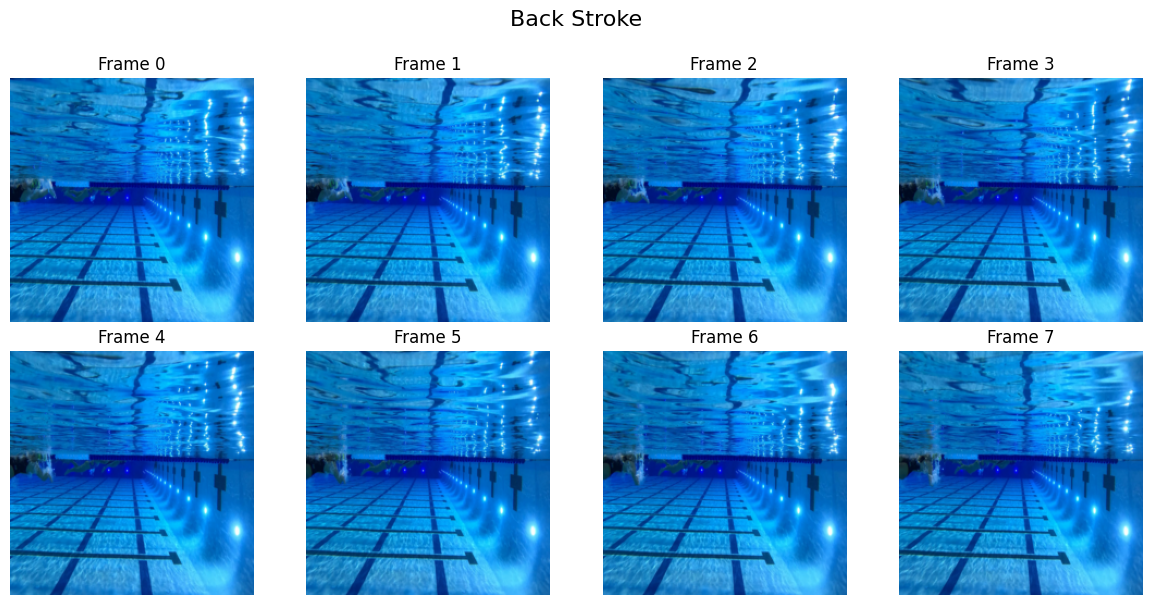

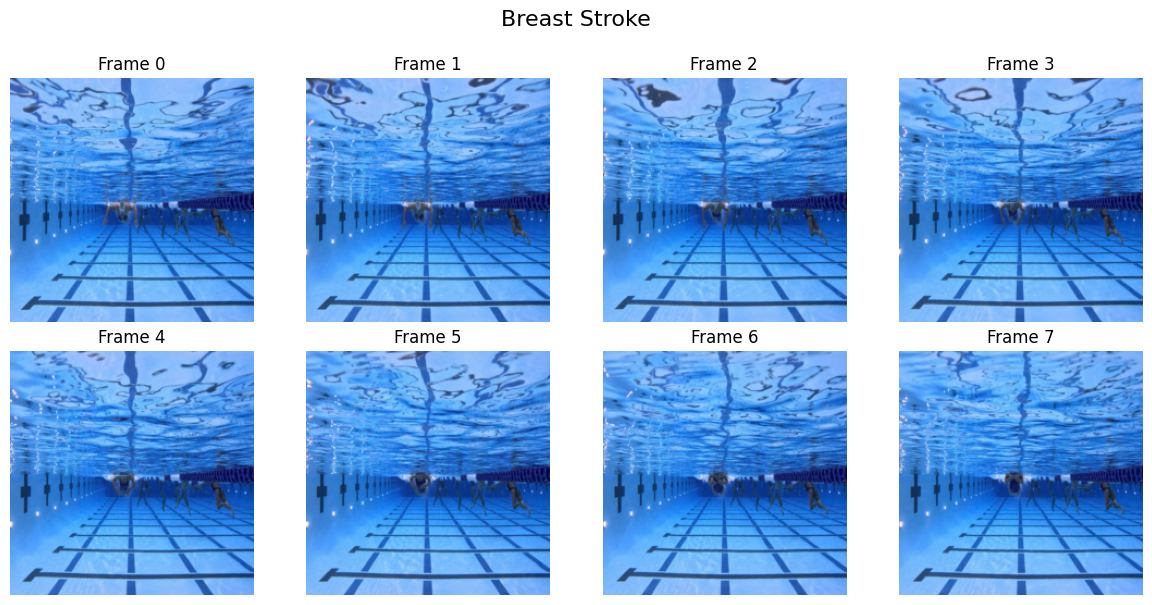

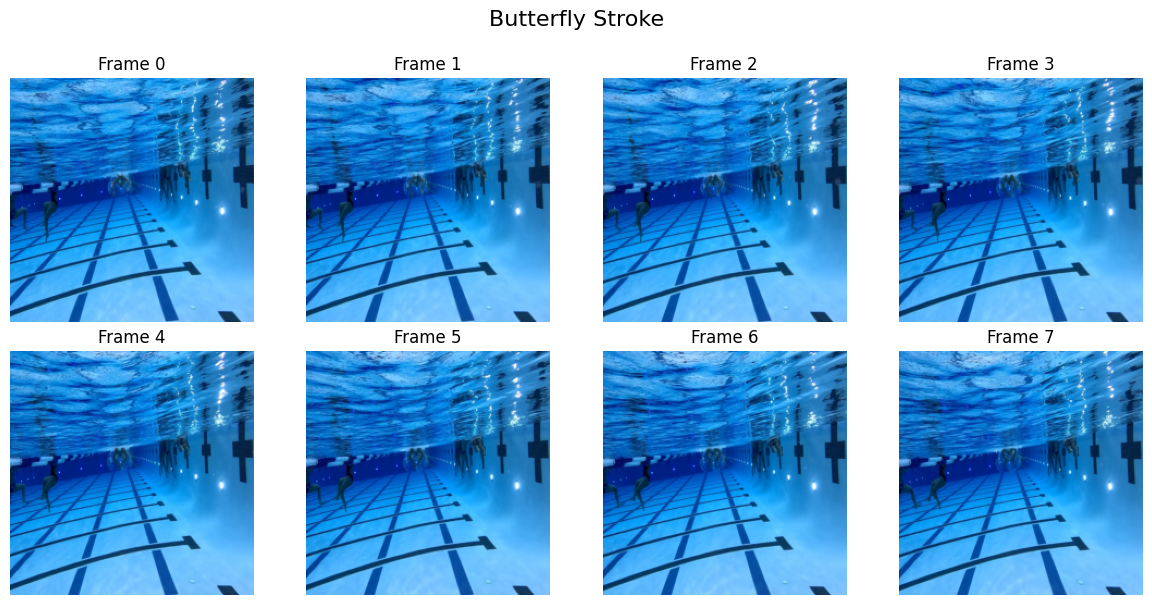

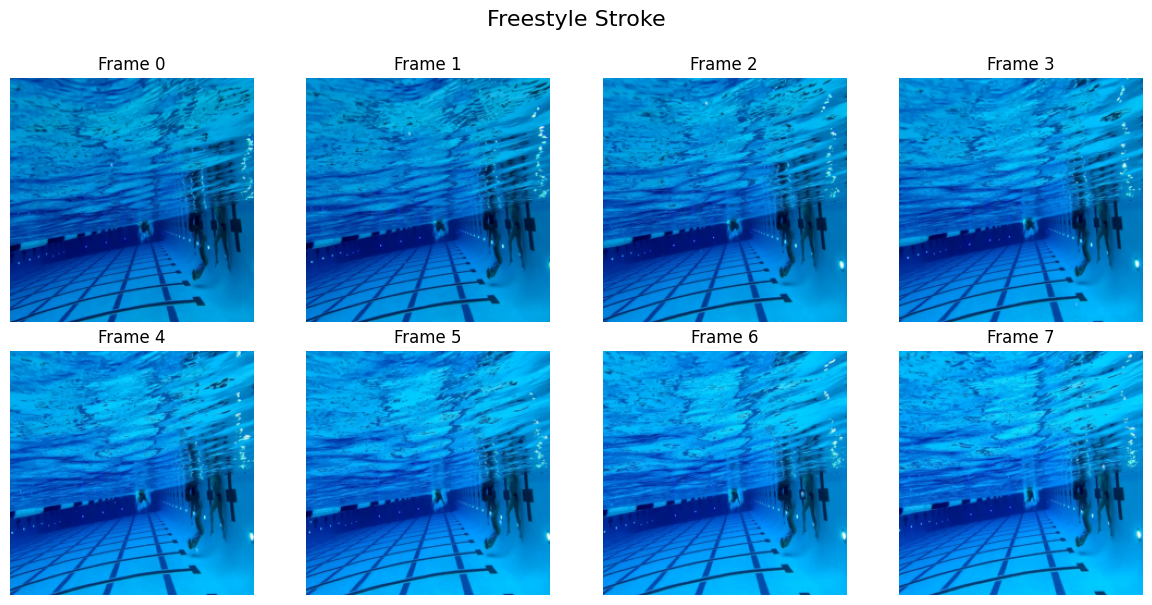

In [7]:
# Visualize processed videos
show_frames(back_video, title='Back Stroke')
show_frames(breast_video, title='Breast Stroke')
show_frames(fly_video, title='Butterfly Stroke')
show_frames(free_video, title='Freestyle Stroke')

#### Advanced Image Pre-Processing (if needed)

In [8]:
# Advanced Image Processing
# Image denoising: smoothing, blurring, filtering, sharpening
""" We won't want to smooth or blur for our use case. 
    In lecture professor said, the blue water and bubbles makes it hard to segment swimmers from rest of image. 
    If anything, we want to sharpen image & detect edges."""

## Edge-preserving smoothing filter: bilateral filter?

## Image sharpening: Laplacian filter, Unsharp masking

## Edge detection: Canny operator

# Image enhancement
## Contrast enhancement: histogram equalization

" We won't want to smooth or blur for our use case. \n    In lecture professor said, the blue water and bubbles makes it hard to segment swimmers from rest of image. \n    If anything, we want to sharpen image & detect edges."

### Task 1: Swimmer Segmentation with SAM
Description:

Use Meta’s SAM model to isolate the swimmer from each frame provided.

Instructions:
1. Load the provided dataset of swimmer images.
2. Apply SAM to each image to segment the swimmer, separating them from the background.
3. Save the segmented images for the next task.

Meta SAM Github: https://github.com/facebookresearch/segment-anything

In [9]:
# Import libraries
import matplotlib.pyplot as plt
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# Data Types
from matplotlib.axes import Axes

# Check if GPU is available for PyTorch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
def show_mask(mask: ndarray, ax: Axes, random_color: bool = False) -> None:
    """ 
    Display Segmentation Mask produced by Meta SAM model for an image.
    
    Parameters:
        mask (ndarray): Segmentation Mask to display
        ax (Axes): Axes/plot to plot mask on
        random_color (bool): flag for generating random colored masks
    """
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 255/255, 0/255, 0.6])             # Changed default mask to green because of blue water background
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)    # Reshape mask
    ax.imshow(mask_image)                                           # Plot mask
    
def show_points(coords: ndarray, labels: ndarray, ax: Axes, marker_size: int = 375) -> None:
    """ 
    Display segmentation points inputted to Meta SAM model for an image.

    Parameters:
        coords (ndarray): coordinates of segmentation points to display
        labels (ndarray): labels, generated by Meta SAM, for segmentation points (1 - foreground point, 0 - background point)
        ax (Axes): Axes/plot to plot points on
        marker_size (int): point marker size
    """
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [11]:
# Meta Segment Anything Model (SAM) variables
MODEL_PATH = 'models/sam_vit_b_01ec64.pth'
SAM_TYPE = 'vit_b'

# Load Meta SAM variant
sam = sam_model_registry[SAM_TYPE](checkpoint=MODEL_PATH)
sam.to(device=device)
print("SAM Model loaded")

SAM Model loaded


In [41]:
# Load images to segment
# image = cv2.imread('data/input/back_00000.png') # TODO: Loop through and segment all images - Segmenting 1 image for testing purposes
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = get_frame(back_video, 32) # Get first frame from back video

In [37]:
# Initialize points to segment image
# TODO: we need to find a way to set this at the swimmer
input_point = np.array([[112, 112]])
input_label = np.array([1])

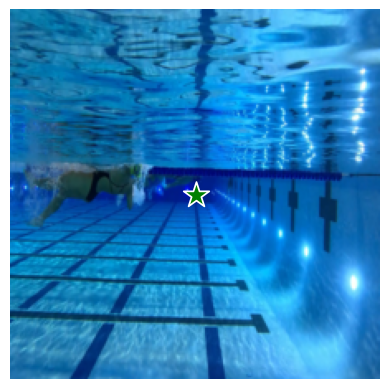

In [47]:
# Display image with segmentation point
plt.imshow(to_pil_image(denormalize_image(image)))
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()  

In [43]:
# Image Segmentation w/ Meta SAM
predictor = SamPredictor(sam)
predictor.set_image(image)

In [44]:
# Segment image based on input segmentation points & labels
# Get masks, scores, and log probabilities of predicted masks
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
masks.shape  # (number_of_masks) x H x W

(3, 3, 224)

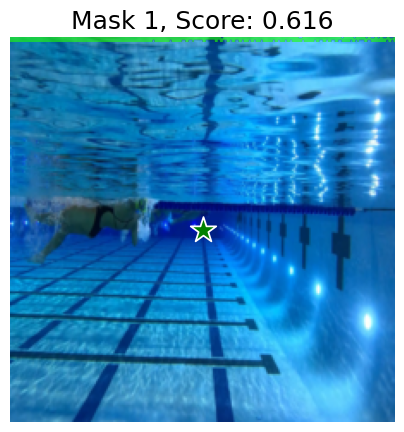

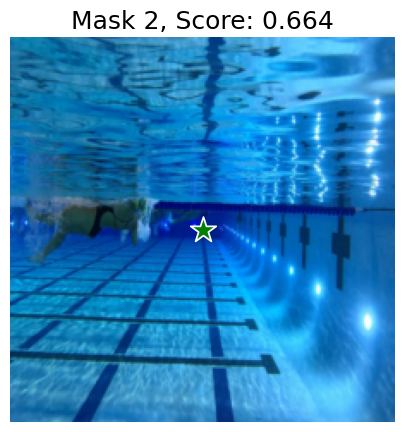

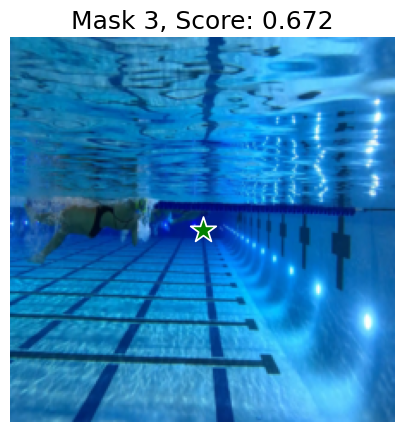

In [50]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    # Visualize image + masks + segmentation points + scores
    plt.figure(figsize=(5,5))
    plt.imshow(to_pil_image(denormalize_image(image)))
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

In [ ]:
# Image segmentation w/ multiple segmentation points
input_point = np.array([[50, 112], [200, 112]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [52]:
# Segment image using top scoring mask
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)
masks.shape

(1, 3, 224)

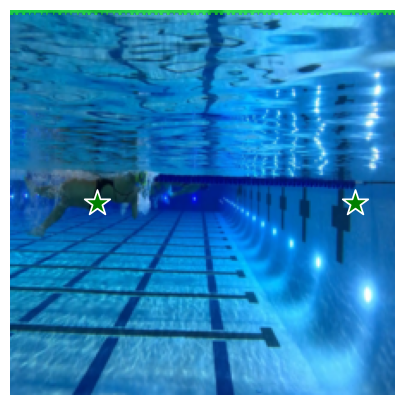

In [ ]:
# Visualize segmented image using w/ top scoring mask
plt.figure(figsize=(5,5))
plt.imshow(to_pil_image(denormalize_image(image)))
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

### Task 2: Pose Estimation on the Segmented Swimmer

Description:

With the segmented swimmer images, utilize a human pose estimation model to
detect the swimmer’s joints.

Model Options:
1. YOLO (congured for pose estimation).
2. Meta Sapiens

Instructions:
1. Choose either YOLO or Meta Sapiens for pose estimation.
2. Run the selected model on the segmented images to identify key joint positions.
3. Save images with overlaid joint positions and export joint coordinates for each frame.


Ultralytics YOLOv11 Pose Estimation Docs: https://docs.ultralytics.com/tasks/pose/

In [12]:
# Import libraries
from ultralytics import YOLO

In [13]:
# Initialize Pose Estimation Model
model = YOLO('models/yolo11n-pose.pt')

In [ ]:
# Identify key joint positions
results = model.track('back_training.mp4', show=True, save=True)

In [ ]:
# Overlay images with joint positions

In [ ]:
# Save overlaid images, save keypoint coordinates in csv file